<a href="https://colab.research.google.com/github/ziatdinovmax/gpax/blob/main/examples/gpax_GPBO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian process-based Bayesian optimization

*Prepared by Maxim Ziatdinov (2022). Last updated in May 2023.*

As described in earlier examples, Gaussian process (GP) is a powerful tool for reconstructing an unknown function from sparse measurements in the probabilistic fashion. In addition to providing a "one-off" reconstruction, the GP's posterior predictive mean and uncertainty can be used to derive an acquisition function for selecting the next point to measure in the optimization problems. In the fully Bayesian regime, the next measurement point is selected according to

$$ x_{next}= \underset{x}{\arg\max}\frac{1}{L}∑_{i=1}^Lα(𝜇_*^i,𝓥_*^i)\qquad (1) $$

where $L$ is the total number of Hamiltonian Monte Carlo samples,  $𝜇_*^i$ is a posterior predictive mean, and $𝓥_*^i$ is a posterior predictive variance for *i*-th sample. Perhaps the simplest acquisition function is an upper confidence bound (UCB) defined as

$$ α_{UCB}^i= 𝜇_*^i\pm\sqrt{𝛽\space 𝓥_*^i}\qquad (2) $$

where the square root of $𝓥_*$ is a standard deviation (‘uncertainty’). The coefficient $𝛽$ determines an exploitation-exploration trade-off. The '$+$' sign corresponds to the maximization problems, whereas the '$-$' sign is for the minimization problems. In the variational inference regime, $L=1$, and the next point is selected as $x_{next}=\arg\max_xα(𝜇_*,𝓥_*)$.

For the analytical acquisition function such as UCB, one may alternatively first derive mean and variance of the sampled predictions (```y_sampled``` in GPax code examples) and then use them to compute the acqusition function.


Install GPax:

In [ ]:
!pip install git+https://github.com/ziatdinovmax/gpax

Imports:

In [9]:
import gpax
import numpy as np
import matplotlib.pyplot as plt

import numpyro

gpax.utils.enable_x64()

Let's define a function to be minimized and a function that emulates a noisy measurement:

In [10]:
def func(x, y=1.2):
    out = (
        -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
        - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))
        + np.e + 20
    )
    return out

def measure(x, noise=0.1):
    return func(x) + noise * np.random.randn(len(x))

Next, we generate a few noisy observations of our function. We also plot the true function ("ground truth") to confirm the location of the minimum at $x=0$ but we are not going to use it anywhere.

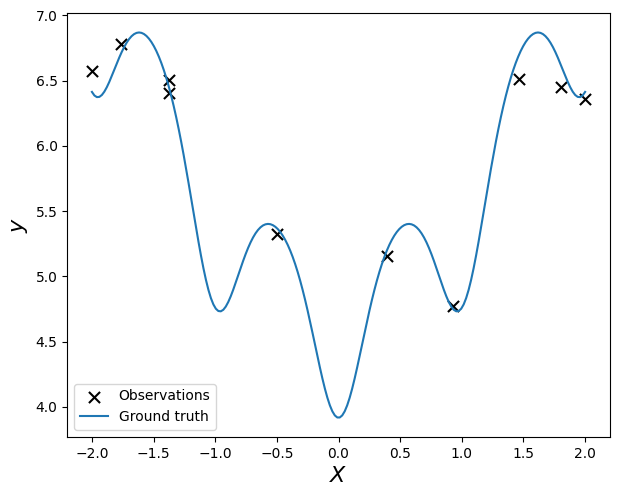

In [11]:
np.random.seed(42)

X_bounds = np.array([-2, 2])
X = np.random.uniform(X_bounds[0], X_bounds[1], size=(8,))
X = np.append(X, X_bounds)
X = np.sort(X)
y = measure(X)

X_unmeasured = np.linspace(X_bounds[0], X_bounds[1], 200)
ground_truth = measure(X_unmeasured, noise=0)


_, ax = plt.subplots(dpi=100, figsize=(7, 5.5))
ax.set_xlabel("$X$", fontsize=16)
ax.set_ylabel("$y$", fontsize=16)
ax.scatter(X, y, marker='x', c='k', s=64, zorder=1, label="Observations", alpha=1.0)
ax.plot(X_unmeasured, ground_truth, label='Ground truth')
ax.legend(loc='best');

The Gaussian process class in GPax uses a weakly informative $LogNormal(0,1)$ prior distribution for all kernel parameters and model noise by default. If we have prior knowledge that the noise level is low, we may choose a more appropriate prior distibution for the noise, such as

In [12]:
noise_prior = numpyro.distributions.HalfNormal(0.01)

Next we define a single step that takes measured data, trains a GP model, and uses it to compute an Upper Confidence Bound (UCB) acquisition function for deriving the next measurment point (which will be done inside the main loop).

In [13]:
def step(X_measured, y_measured, X_unmeasured):
    # Get random number generator keys for training and prediction
    rng_key1, rng_key2 = gpax.utils.get_keys()
    # Initialize GP model
    gp_model = gpax.ExactGP(1, kernel='RBF', noise_prior_dist=noise_prior)
    # Run HMC to obtain posterior samples for the GP model parameters
    gp_model.fit(rng_key1, X_measured, y_measured)
    # Get predictions (we don't need this step for optimization - only for visualization purposes)
    y_pred, y_sampled = gp_model.predict(rng_key2, X_unmeasured, noiseless=True)
    # Compute acquisition function
    obj = gpax.acquisition.UCB(
        rng_key2, gp_model, X_unmeasured, beta=4,
        maximize=False, noiseless=True)
    return obj, (y_pred, y_sampled)

Finally, we run the Bayesian optimization for 7 steps to find the minimum of the unknown (to the algorithm) function:


Step 1/7


sample: 100%|██████████| 4000/4000 [00:06<00:00, 594.88it/s, 7 steps of size 3.98e-01. acc. prob=0.96]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.76      0.15      0.74      0.54      0.94    470.72      1.00
    k_scale     12.88      5.87     11.61      5.43     20.58   1199.93      1.00
      noise      0.01      0.01      0.01      0.00      0.02    558.75      1.00



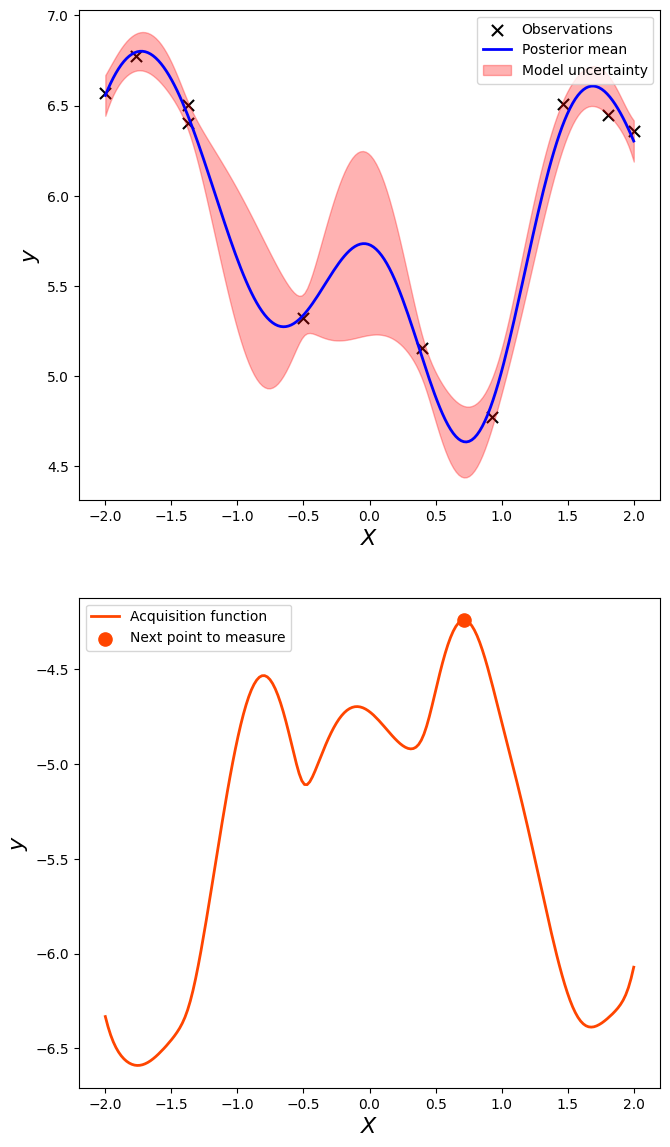


Step 2/7


sample: 100%|██████████| 4000/4000 [00:03<00:00, 1065.65it/s, 15 steps of size 3.27e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.08      0.41      0.95      0.45      1.79    353.09      1.00
    k_scale     11.76      5.91     10.53      4.61     19.10    671.04      1.00
      noise      0.02      0.01      0.02      0.01      0.04    479.63      1.00



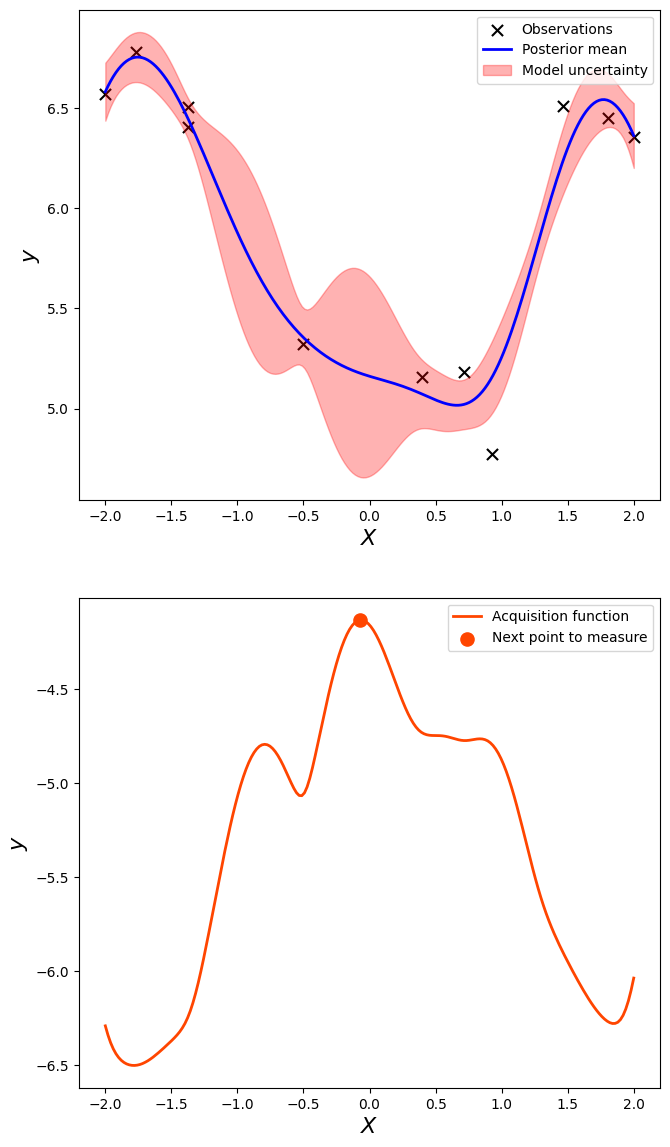


Step 3/7


sample: 100%|██████████| 4000/4000 [00:04<00:00, 991.73it/s, 3 steps of size 4.88e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.53      0.06      0.53      0.44      0.63    979.11      1.00
    k_scale     14.22      6.07     12.96      6.43     22.51   1339.20      1.00
      noise      0.01      0.01      0.01      0.00      0.02   1429.83      1.00



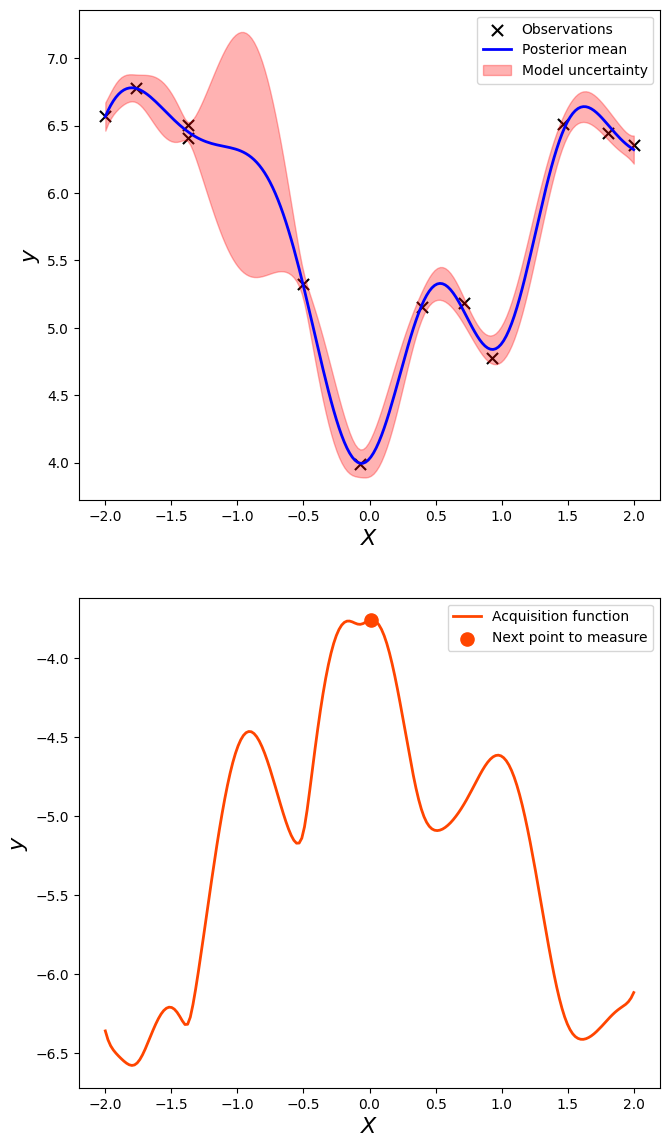


Step 4/7


sample: 100%|██████████| 4000/4000 [00:04<00:00, 997.82it/s, 7 steps of size 4.52e-01. acc. prob=0.96] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.51      0.05      0.51      0.43      0.61    995.34      1.00
    k_scale     14.25      6.05     13.04      6.11     22.16   1270.28      1.00
      noise      0.01      0.01      0.01      0.00      0.02   1330.58      1.00



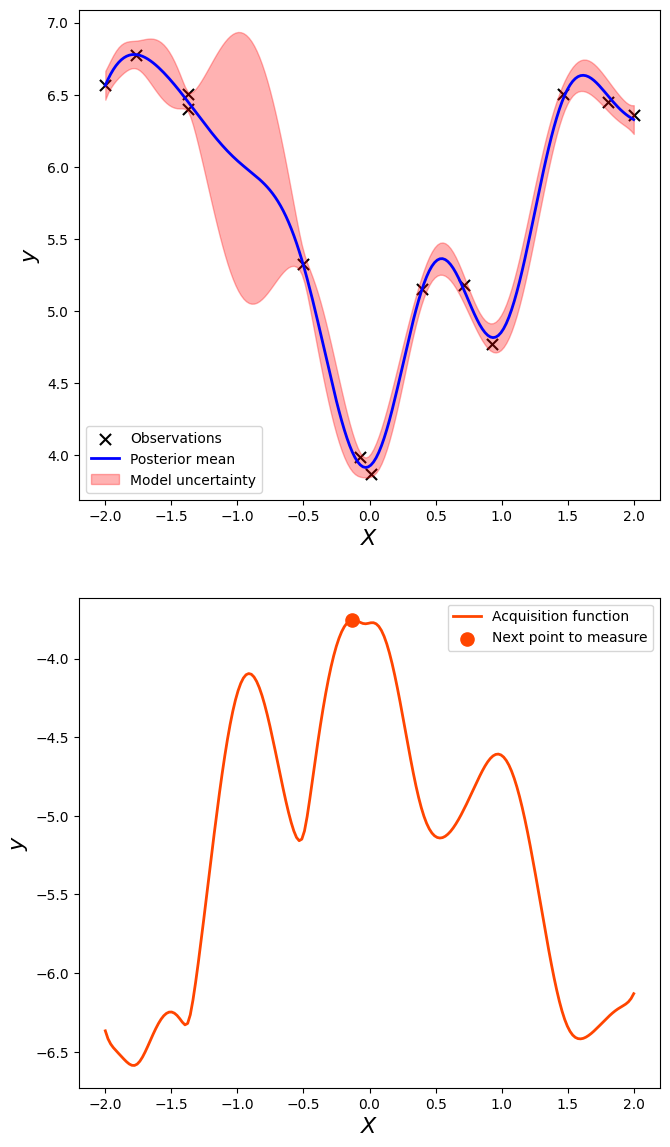


Step 5/7


sample: 100%|██████████| 4000/4000 [00:04<00:00, 959.90it/s, 7 steps of size 4.74e-01. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.49      0.05      0.49      0.41      0.57   1038.09      1.00
    k_scale     14.10      5.75     12.85      6.14     21.57   1341.46      1.00
      noise      0.01      0.01      0.01      0.00      0.02   1294.16      1.00



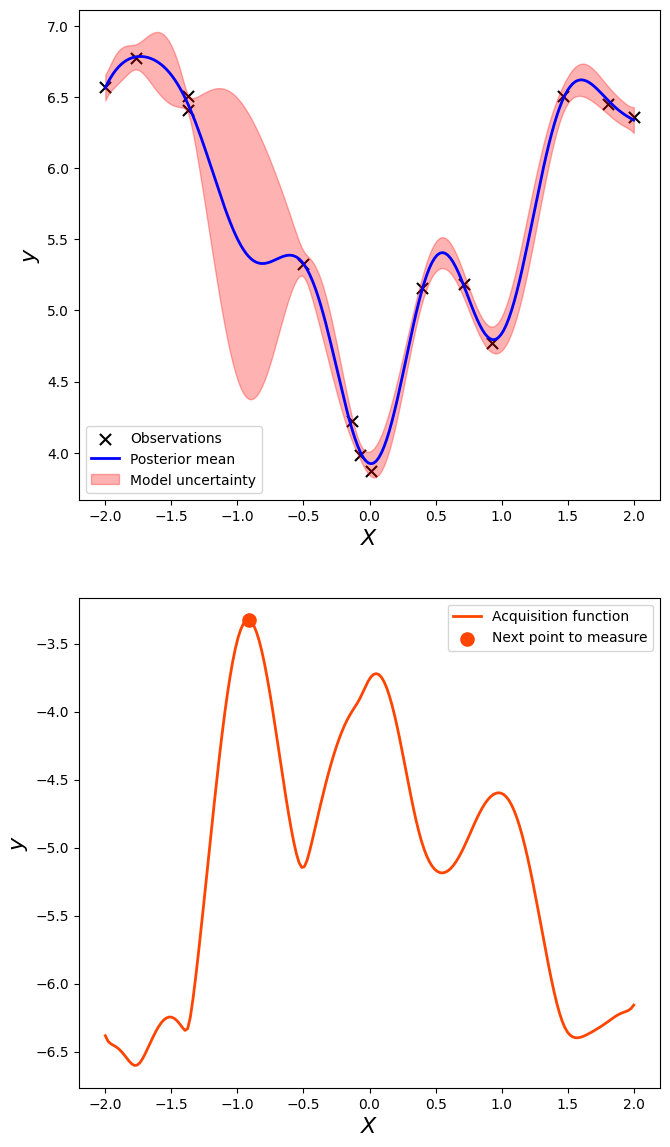


Step 6/7


sample: 100%|██████████| 4000/4000 [00:03<00:00, 1041.61it/s, 7 steps of size 5.33e-01. acc. prob=0.95]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.48      0.04      0.49      0.43      0.55   1452.11      1.00
    k_scale     14.16      5.81     12.89      5.72     21.49   1015.06      1.00
      noise      0.01      0.00      0.01      0.00      0.01   1807.34      1.00



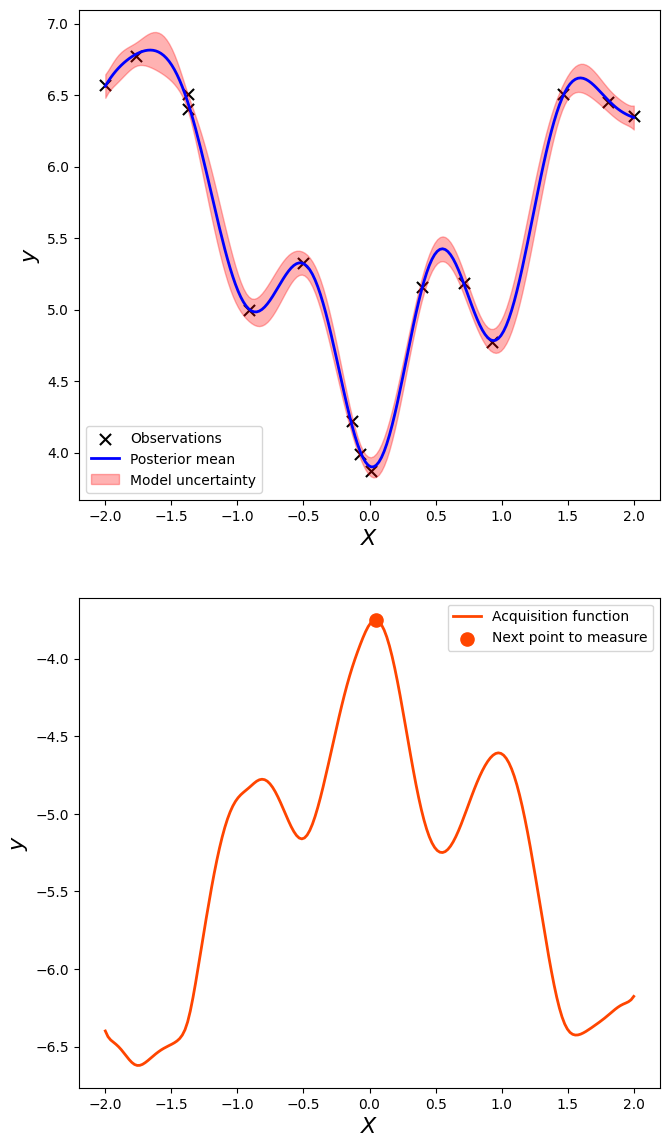


Step 7/7


sample: 100%|██████████| 4000/4000 [00:03<00:00, 1080.97it/s, 7 steps of size 6.77e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.48      0.04      0.48      0.42      0.54   1240.54      1.00
    k_scale     14.39      5.91     13.06      6.22     21.58   1141.66      1.00
      noise      0.01      0.00      0.01      0.00      0.01   1550.50      1.00



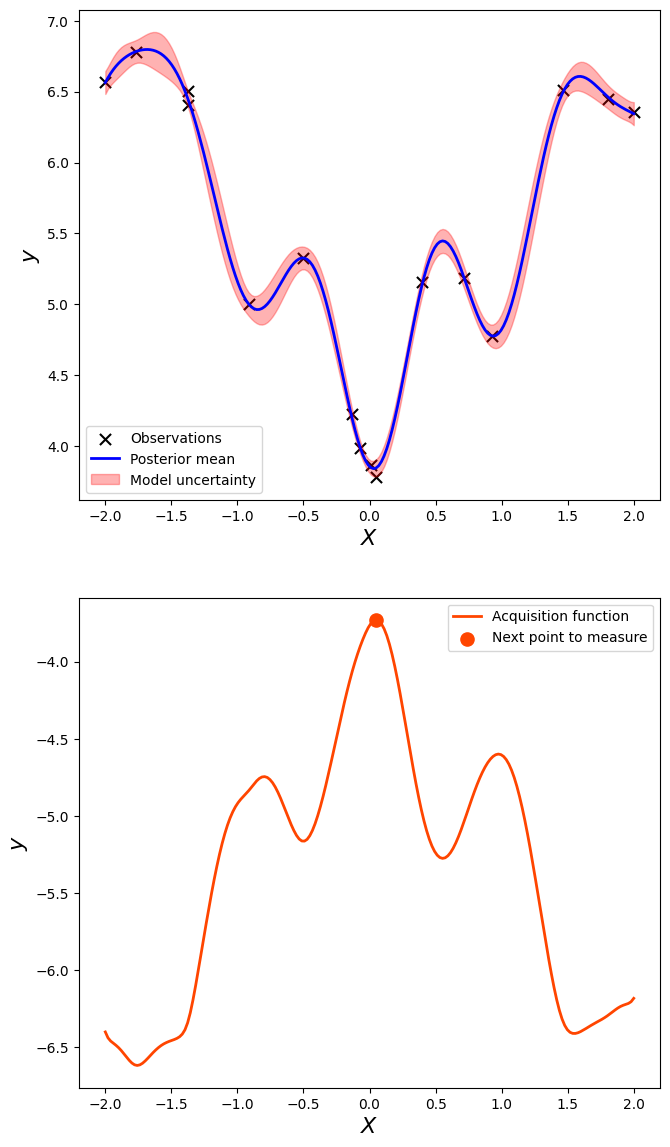

In [14]:
num_steps = 7

for e in range(num_steps):
    print("\nStep {}/{}".format(e+1, num_steps))
    # Compute acquisition function
    acq, (y_pred, y_sampled) = step(X, y, X_unmeasured)
    # Get the next point to evaluate
    idx = acq.argmax()
    next_point = X_unmeasured[idx:idx+1]
    # Measure the point
    next_point_value = measure(next_point)
    # Update measured data
    X = np.append(X, X_unmeasured[idx:idx+1])
    y = np.append(y, next_point_value)

    # Plot observed points, mean prediction, and acqusition function
    lower_b = y_pred - y_sampled.std(axis=(0,1))
    upper_b = y_pred + y_sampled.std(axis=(0,1))
    fig, (ax1, ax2) = plt.subplots(2, 1, dpi=100, figsize=(7.5, 14))
    ax1.scatter(X[:-1], y[:-1], marker='x', c='k', label="Observations", s=64)
    ax1.plot(X_unmeasured, y_pred, lw=2, c='b', label='Posterior mean')
    ax1.fill_between(X_unmeasured, lower_b, upper_b, color='r', alpha=0.3, label="Model uncertainty")
    ax2.plot(X_unmeasured, acq, lw=2, c='orangered', label='Acquisition function')
    ax2.scatter(X_unmeasured[idx], acq[idx], s=90, c='orangered', label='Next point to measure')
    for ax in fig.axes:
        ax.set_xlabel("$X$", fontsize=16)
        ax.set_ylabel("$y$", fontsize=16)
        ax.legend(loc='best', fontsize=10)
    plt.show()

As one can see, the algorithm quickly converged onto the true minimum. Note that in real experiments, it's practical to update the ```X_unmeasured``` at each step by removing the just measured point from it.